In [ ]:
from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
import dpdata
import glob
import seaborn as sns
import pandas as pd
import os

from sklearn.decomposition import PCA
from dpeva.sampling.direct import BirchClustering, DIRECTSampler, SelectKFromClusters

Initializing DP-EVA version 0.1.0


In [2]:
# load data
desc_string = 'descriptors/*/desc.npy'
dpdata_name = "FeCHO-clean-v2-7-20873"
dpdata_path = "./data-clean-v2-7-20873-npy"
dpdata_string = "O*"

In [3]:
# read descriptors/*/desc.npy data
print("Reading descriptor results...")
desc_names = []
desc_keys = []
desc_stru = []
desc_perstru = []
iter_list = sorted(glob.glob(desc_string))
for f in iter_list:
    # extract dirname of desc.npy from descriptors/*
    directory, _ = os.path.split(f)
    _, keyname = os.path.split(directory)
    desc_names.append(keyname)
    one_desc = np.load(f) # nframe, natoms, ndesc
    for ind in range(len(one_desc)):
        desc_keys.append(f"{keyname}-{ind}")
        desc_perstru.append(one_desc[ind])
    # do average in natoms dimension
    one_desc_stru = np.mean(one_desc, axis=1)
    desc_stru.append(one_desc_stru)
desc_stru = np.concatenate(desc_stru, axis=0)
np.shape(desc_stru)

Reading descriptor results...


(20873, 136)

In [5]:
# read dpdata for element type information 
#print("Reading corresponding dpdata...")
alldata =  dpdata.MultiSystems.from_dir(dpdata_path, dpdata_string, fmt="deepmd/npy")
alldata

MultiSystems (694 systems containing 20873 frames)

In [6]:
alldata_list = []
for lbsys in alldata:
    for sys in lbsys:
        alldata_list.append(sys)

## plot structural and atomic feature space
In the MatPES manuscript, the 2-DIRECT method is aiming to choose the STRU with minimum number of atoms in the mixture of unitcell and supercell trajectory, while add supercell when necessary (having unique atomic features).

So, the most important thing is the dealing with atomic features

### step 1: Partition 20,837 structures into 40 groups according to location in structural feature space

In [25]:
%%time
DIRECT_partitioner = DIRECTSampler(
    structure_encoder=None,
    clustering=BirchClustering(n=40, threshold_init=0.5),
    select_k_from_clusters=None,
)

CPU times: user 49 μs, sys: 16 μs, total: 65 μs
Wall time: 68.7 μs


In [26]:
%%time
DIRECT_partition = DIRECT_partitioner.fit_transform(desc_stru)

2025-03-24 22:20:02,029 - INFO - Selected first 16 PCs, explaining 91.26% variance
2025-03-24 22:20:03,874 - INFO - BirchClustering with threshold_init=0.5 and n=40 gives 40 clusters.


CPU times: user 1.14 s, sys: 2.13 s, total: 3.26 s
Wall time: 1.9 s


#### Visualize the partition results

In [27]:
explained_variance = DIRECT_partitioner.pca.pca.explained_variance_
selected_PC_dim = len([e for e in explained_variance if e > 1])
DIRECT_partition["PCAfeatures_unweighted"] = DIRECT_partition["PCAfeatures"] / explained_variance[:selected_PC_dim]
all_features = DIRECT_partition["PCAfeatures_unweighted"]

<Axes: xlabel='pc1', ylabel='pc2'>

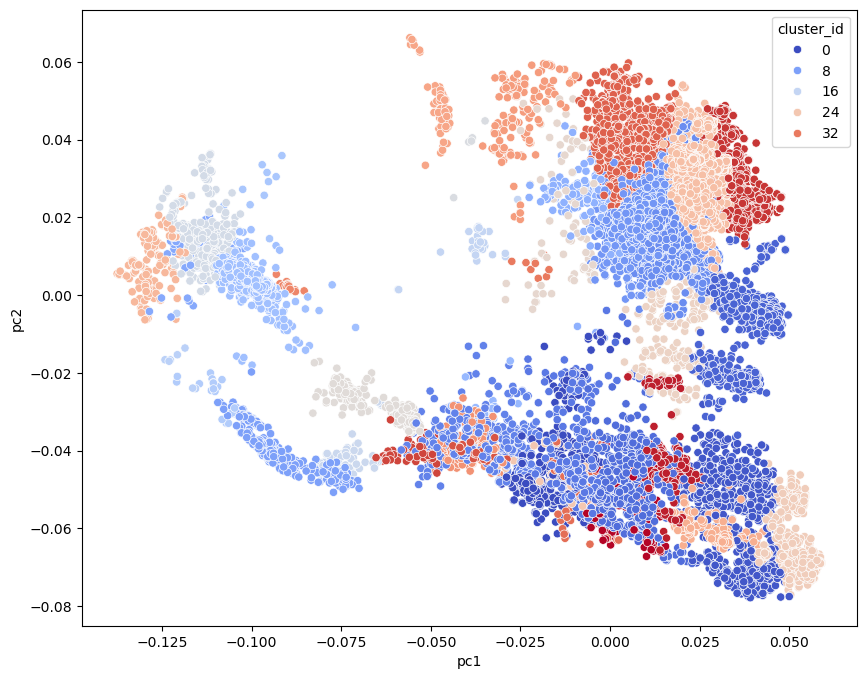

In [28]:
df_partition = pd.DataFrame(
    {
        "pc1": all_features[:, 0],
        "pc2": all_features[:, 1],
        "cluster_id": DIRECT_partition["labels"],
        "sys_name": desc_keys
    }
)

plt.figure(figsize=(10, 8))
sns.scatterplot(df_partition, 
                x="pc1", 
                y="pc2", 
                hue="cluster_id", 
                palette="coolwarm")

### Step 2: DIRECT sampling 100 structures from each cluster according to atomic features and structure size

In [38]:
%%time
# most important part
sampled_structure_ids = []
for label in set(DIRECT_partition["labels"]):
    # do cluster in struc_cluster based on atomic features and natoms
    structure_ids = np.where(DIRECT_partition["labels"]==label)[0]
    atom_features = [
        af 
        for ind,afs in enumerate(desc_perstru) 
        if ind in structure_ids 
        for af in afs
    ]
    # double for in list like the same double for extended
    natoms = []
    structure_ids_atomf = []
    for ind,sys in enumerate(alldata_list):
        for natom in np.ones(sys.get_natoms()) * sys.get_natoms():
            if ind in structure_ids:
                natoms.append(natom)
                structure_ids_atomf.append(ind)
    
    assert len(atom_features) == len(natoms)
    assert len(structure_ids_atomf) == len(natoms)
    
    # select structures with smallest natoms based on atomic features
    direct_sampler = DIRECTSampler(None,
                                   clustering=BirchClustering(
                                       n = 93, 
                                       threshold_init = 0.1),
                                   select_k_from_clusters = SelectKFromClusters(
                                       k = 5,
                                       selection_criteria = "smallest", 
                                       n_sites = natoms
                                   )
                                  )   # try to use to center of cluster
    DIRECT_sampling = direct_sampler.fit_transform(np.array(atom_features))
    struct_ids = list(set([structure_ids_atomf[ind] for ind in DIRECT_sampling["selected_indices"]]))
    sampled_structure_ids.extend(struct_ids)
sampled_structure_ids = list(set(sampled_structure_ids))
print(f"Selected in total {len(sampled_structure_ids)} smallest possible structures with 2-DIRECT")

2025-03-24 22:57:37,239 - INFO - Selected first 16 PCs, explaining 88.91% variance
2025-03-24 22:57:38,781 - INFO - BirchClustering with threshold_init=0.1 and n=93 gives 93 clusters.
2025-03-24 22:57:38,833 - INFO - Finally selected 455 configurations.
2025-03-24 22:57:42,108 - INFO - Selected first 15 PCs, explaining 89.81% variance
2025-03-24 22:57:44,241 - INFO - BirchClustering with threshold_init=0.1 and n=93 gives 93 clusters.
2025-03-24 22:57:44,305 - INFO - Finally selected 456 configurations.
2025-03-24 22:57:47,732 - INFO - Selected first 14 PCs, explaining 88.95% variance
2025-03-24 22:57:51,134 - INFO - BirchClustering with threshold_init=0.1 and n=93 gives 93 clusters.
2025-03-24 22:57:51,236 - INFO - Finally selected 463 configurations.
2025-03-24 22:57:54,220 - INFO - Selected first 17 PCs, explaining 87.93% variance
2025-03-24 22:57:55,874 - INFO - BirchClustering with threshold_init=0.1 and n=93 gives 93 clusters.
2025-03-24 22:57:55,938 - INFO - Finally selected 463 

Selected in total 3989 smallest possible structures with 2-DIRECT
CPU times: user 3min 49s, sys: 1min 45s, total: 5min 35s
Wall time: 3min 54s


In [39]:
from copy import deepcopy
sampled_stru_ids_mini_natom = deepcopy(sampled_structure_ids)

In [ ]:
def plot_feature_coverage(selected_indices,
                          all_structures,
                          all_features,
                          all_features_atoms,
                          method="2DIRECT"):
    fig, ax = plt.subplots(figsize=(10, 8))
    ave_all = round(np.mean([s.get_natoms() for s in all_structures]))
    ave_selected = round(np.mean([s.get_natoms() for i,s in enumerate(all_structures) if i in selected_indices]))
    
    # do PCA on all_features
    pca_desc_stru = PCA(n_components=2)
    PCs_desc_stru = pca_desc_stru.fit_transform(all_features)
    selected_features = PCs_desc_stru[selected_indices]
    
    plt.plot(PCs_desc_stru[:, 0], 
             PCs_desc_stru[:, 1], 
             "*", alpha=0.5,
             label=f"All {len(all_features):,} structures, nsite$_{{ave}}$={ave_all}")
    plt.plot(
        selected_features[:, 0],
        selected_features[:, 1],
        "*",
        alpha=0.5,
        label=f"{method} sampled {len(selected_features):,} structures, nsite$_{{ave}}$={ave_selected}",
    )
    plt.legend(frameon=False, fontsize=12, reverse=False)
    plt.xlabel("1st dimension", fontsize=14)
    plt.ylabel("2nd dimension", fontsize=14)
    plt.title("DPA-2 structural feature", fontsize=18)
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 8))
    all_features_atoms_flatten = np.concatenate(all_features_atoms, axis=0)
    
    # do PCA on all_features
    pca_desc_atom = PCA(n_components=2)
    PCs_desc_atom = pca_desc_atom.fit_transform(all_features_atoms_flatten)
    print(np.shape(PCs_desc_atom))
    
    PCs_desc_atom_selected = np.concatenate([
        pca_desc_atom.transform(af.reshape(1,-1))
        for i,afs in enumerate(all_features_atoms) 
        if i in selected_indices 
        for af in afs], axis=0)
    
    plt.plot(
    PCs_desc_atom[:, 0], PCs_desc_atom[:, 1], "*",
    alpha=0.5, label=f"All {len(PCs_desc_atom):,} atomic environments"
    )
    plt.plot(
    PCs_desc_atom_selected[:, 0], PCs_desc_atom_selected[:, 1], "*",
    alpha=0.5, label=f"{method} selected {len(PCs_desc_atom_selected):,}"
)
    plt.legend(frameon=False, fontsize=12, reverse=False)
    plt.xlabel("1st dimension", fontsize=14)
    plt.ylabel("2nd dimension", fontsize=14)
    plt.title("DPA-2 atomic feature", fontsize=18)

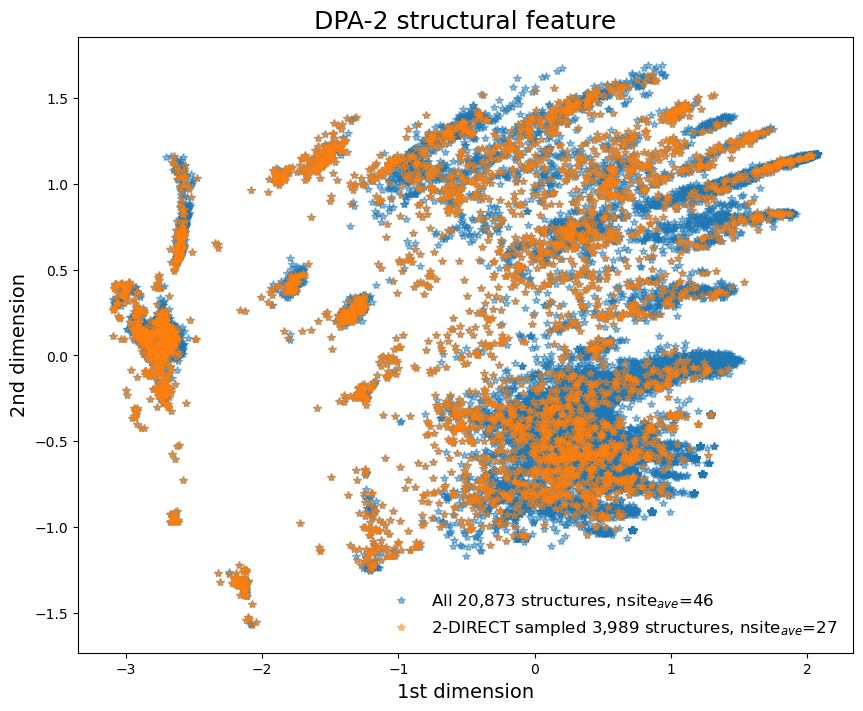

(970512, 2)


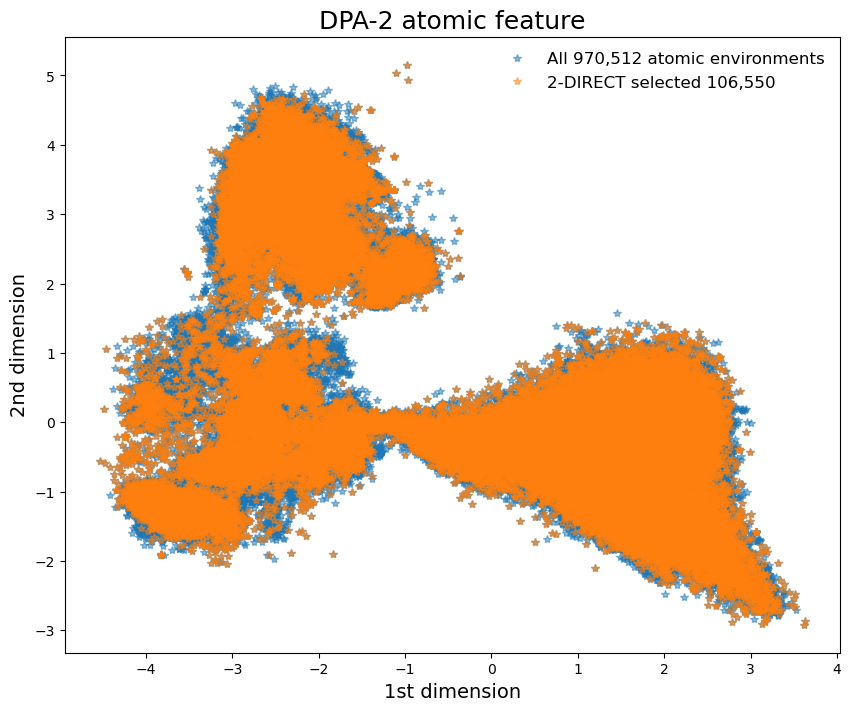

In [42]:
plot_feature_coverage(
    sampled_stru_ids_mini_natom,
    all_structures=alldata_list,
    all_features=desc_stru,
    all_features_atoms=desc_perstru,
    method="2-DIRECT"
    )

In [43]:
# save dpdata
sampled_dpdata = dpdata.MultiSystems()
other_dpdata = dpdata.MultiSystems()
for ind,sys in enumerate(alldata_list):
    if ind in sampled_stru_ids_mini_natom:
        sampled_dpdata.append(sys)
    else:
        other_dpdata.append(sys)
sampled_dpdata

MultiSystems (434 systems containing 3989 frames)

In [44]:
sampled_dpdata.to_deepmd_npy_mixed("sampled-data-2direct-4k")

MultiSystems (434 systems containing 3989 frames)

In [45]:
other_dpdata.to_deepmd_npy("other-data-2direct-4k")

MultiSystems (521 systems containing 16884 frames)